# 1D CNN temporal analysis

Experimento de forecasting (predição) por meio de CNNs de 1 dimensão.

* Atividade PEL219 - GLWT MNIST - Gabriel Melo. Matrícula: 125.304-6

In [16]:
import numpy as np
import kagglehub
import pandas as pd

from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Forecasting with yahoo stocks
https://www.kaggle.com/datasets/arashnic/time-series-forecasting-with-yahoo-stock-price

In [17]:
# Download the forecasting dataset
path = kagglehub.dataset_download("arashnic/time-series-forecasting-with-yahoo-stock-price")
df = pd.read_csv(path + "/yahoo_stock.csv")
df

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
1,2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2,2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
3,2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
4,2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107
...,...,...,...,...,...,...,...
1820,2020-11-16,3628.510010,3600.159912,3600.159912,3626.909912,5.281980e+09,3626.909912
1821,2020-11-17,3623.110107,3588.679932,3610.310059,3609.530029,4.799570e+09,3609.530029
1822,2020-11-18,3619.090088,3567.330078,3612.090088,3567.790039,5.274450e+09,3567.790039
1823,2020-11-19,3585.219971,3543.840088,3559.409912,3581.870117,4.347200e+09,3581.870117


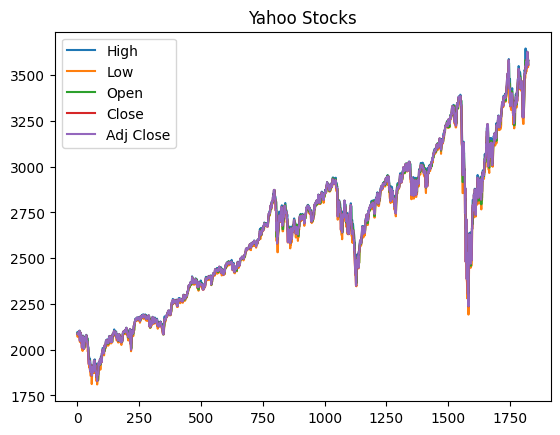

In [18]:
fig = plt.subplot(1,1,1)

for column, values in df.drop(columns=['Date', 'Volume']).items():
    fig.plot(values, label=column)
        
plt.title("Yahoo Stocks")
plt.legend()

plt.show()

In [19]:
def create_sequences(data: np.array, seq_len: int = 5, forecast_len: int = 3):
    """
    create sequence of a original 1d series using a sliding window
    """
    X, y = [], []
    for i in range(len(data) - (seq_len + forecast_len)):
        seek = i+seq_len
        X.append(data[i:seek])
        y.append(data[seek:seek+forecast_len])
    return np.array(X), np.array(y)

In [20]:
X, y = create_sequences(df["Close"].values)

X.shape, y.shape

((1817, 5), (1817, 3))

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=.3)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1271, 5), (1271, 3), (546, 5), (546, 3))

In [22]:
def train_glwt(model: Sequential, X: np.array, Y: np.array, validation_data, optimizer="adam", loss="categorical_crossentropy", _epochs=10):
    histories = []
    
    for i in range(1, len(model.layers)):
        for layer in model.layers[:i]:
            layer.trainable = False
        for layer in model.layers[i:]:
            layer.trainable = True

        model.compile(optimizer, loss)
        
        histories.append(model.fit(x=X, y=Y, epochs=_epochs, validation_data=validation_data))
            
    return histories

In [23]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=5, strides=1, padding="causal", activation='relu', input_shape=(5,1)))
model.add(MaxPooling1D())
model.add(Conv1D(filters=32, kernel_size=2, strides=1, padding="causal", activation='relu', input_shape=(2,1)))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(3))

model.summary()

/home/melo/coding/machine-learning/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 5, 64)          │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 2, 32)          │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 1, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,611 (18.01 KB)

 Trainable params: 4,611 (18.01 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
hist = train_glwt(model, X_train, y_train, (X_test, y_test), optimizer="adam", loss="mean_squared_error", _epochs=30)

Epoch 1/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4258082.5000 - val_loss: 3240329.7500
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 891686.2500 - val_loss: 224907.7344
Epoch 3/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 31548.2324 - val_loss: 8370.8320
Epoch 4/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1481.1187 - val_loss: 6873.6851
Epoch 5/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1260.3831 - val_loss: 6847.3564
Epoch 6/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1259.4222 - val_loss: 6840.9565
Epoch 7/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1260.7791 - val_loss: 6847.2324
Epoch 8/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1258.2211 - val_loss: 6842.4629
Epoch 9/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1257.4001 - val_loss: 6839.3306
Epoch 10/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1263.7874 - val_loss: 6839.1445
Epoch 11/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1262.7870 - val_loss: 6849.28

In [25]:
for layer in model.layers:
    layer.trainable = True

model.compile("adam", "mean_squared_error")
model.fit(x=X_train, y=y_train, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2175.1450 - val_loss: 6790.8496
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1326.0585 - val_loss: 6771.4238
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1248.9529 - val_loss: 6502.3540
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1279.9675 - val_loss: 6545.8979
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1304.8116 - val_loss: 6540.0522
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1294.3689 - val_loss: 6482.1064
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1433.9052 - val_loss: 6516.3789
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1277.3601 - val_loss: 6472.8022
Epoch 9/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1241.0076 - val_loss: 6836.7021
Epoch 10/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1407.8899 - val_loss: 6609.8218
Epoch 11/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1263.1282 - val_loss: 6450.35

## Testing

In [26]:
results = model.predict(X_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [27]:
mae = mean_absolute_error(y_test, results)
mse = mean_squared_error(y_test, results)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - results) / y_test)) * 100  # MAPE is in percentage
r2 = r2_score(y_test, results)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")
print(f"R2: {r2}")

MAE: 50.18835941077152
MSE: 5753.301938739962
RMSE: 75.85052365501481
MAPE: 1.6845305067314027
R2: 0.9044189215836619


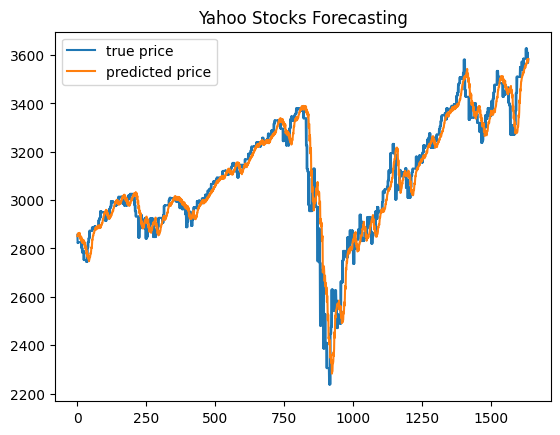

In [28]:
fig = plt.subplot(1,1,1)
fig.plot(y_test.flatten(), label="true price")
fig.plot(results.flatten(), label="predicted price")    
        
plt.title("Yahoo Stocks Forecasting")
plt.legend()

plt.show()

## Training data

In [29]:
hist = [h.history for h in hist]

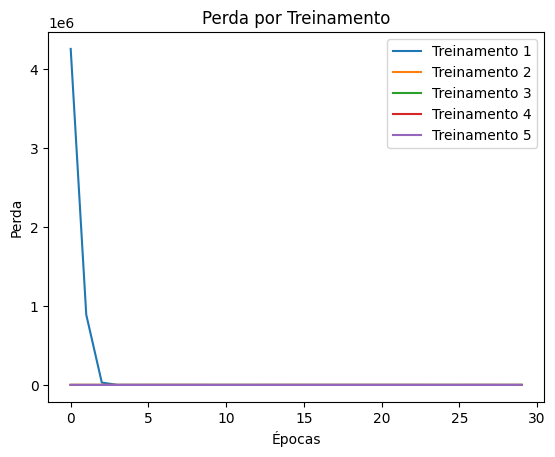

In [30]:
fig = plt.subplot(1,1,1)
for i, h in enumerate(hist):
    fig.plot(h['loss'], label=f'Treinamento {i+1}')
        
plt.title("Perda por Treinamento")
plt.xlabel("Épocas")
plt.ylabel("Perda")
plt.legend()

plt.show()